# Different forget gate biases - 0.1 to 1.0

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

### Data loading

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Hyperparameters

In [3]:
bs = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10']
l_r = 0.01 # Learning rate
epoch = 2000
batch_size = 128

In [4]:
n_inputs = 28 # MNIST data input, img shape = (28, 28), view the graph row by row
n_steps = 28 # Time steps - shift 28 times
n_hidden_units = 128 # Neuron no. in hidden layer
n_classes = 10 # 0~9

### Placeholder - input and output data holders

In [5]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

### Create static initial parameters

In [6]:
# create static initial parameters
w_h1 = tf.random_normal([n_inputs, n_hidden_units])
w_out = tf.random_normal([n_hidden_units, n_classes])
b_h1 = tf.random_normal([n_hidden_units, ])
b_out = tf.random_normal([n_classes, ])

In [7]:
def get_static_w_b():
    # create static initial parameters
    w_h1 = tf.random_normal([n_inputs, n_hidden_units])
    w_out = tf.random_normal([n_hidden_units, n_classes])
    b_h1 = tf.random_normal([n_hidden_units, ])
    b_out = tf.random_normal([n_classes, ])
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        w_h1, w_out, b_h1, b_out = sess.run([w_h1, w_out, b_h1, b_out])
    weights = dict()
    biases = dict()
    for b in bs:
        weights[b] = {
            # (28 inputs, 128 neurons)
            'h1':tf.Variable(tf.constant(w_h1)),
            # (128 inputs, 10 neurons)
            'out':tf.Variable(tf.constant(w_out))
        }
        biases[b] = {
            # (128 neurons, )
            'h1':tf.Variable(tf.constant(b_h1)),
            # (10 neurons, )
            'out':tf.Variable(tf.constant(b_out))
        }
    return weights, biases

### RNN structure

In [8]:
def RNN(X, weights, biases, b='b1'):
    # h1
    X = tf.reshape(X, [-1, n_inputs])
    X_in = tf.matmul(X, weights[b]['h1']) + biases[b]['h1']
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])
    f_b = float(b[1:])/10
    with tf.variable_scope(b):
        # rnn cell
        rnn_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units,
                                                              forget_bias=f_b,
                                                              state_is_tuple=True)
        _init_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
        # outputs: the rnns outputs
        outputs, states = tf.nn.dynamic_rnn(cell=rnn_cell,
                                            inputs=X_in,
                                            initial_state=_init_state,
                                            time_major=False)
    
    # output layer
    outputs = tf.unstack(tf.transpose(outputs, [1, 0, 2]))
    results = tf.matmul(outputs[-1], weights[b]['out']) + biases[b]['out']
    
    return results

In [9]:
def get_pred(x, weights, biases):
    pred = dict()
    for b in bs:
        pred[b] = RNN(x, weights, biases, b=b)
    return pred

def get_loss(pred, y):
    loss = dict()
    for b in bs:
        loss[b] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred[b], labels=y))
    return loss

def get_accu(pred, y):
    accu = dict()
    for b in bs:
        accu[b] = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred[b], 1), tf.argmax(y, 1)), tf.float32))
    return accu

def get_op(loss, l_r):
    train_op = dict()
    for b in bs:
        train_op[b] = tf.train.GradientDescentOptimizer(l_r).minimize(loss[b])
    return train_op

In [10]:
ex_time = 0

### Experiments

In [11]:
import time
test_batch_size = batch_size
loss_val_train = dict()
loss_val_test = dict()
accu_val_train = dict()
accu_val_test = dict()
for b in bs:
    loss_val_train[b] = list()
    loss_val_test[b] = list()
    accu_val_train[b] = list()
    accu_val_test[b] = list()
for ex in range(10):
    ex_time += 1
    # initialize each experiment parameters 
    with tf.variable_scope('ex'+str(ex_time)):
        weights, biases = get_static_w_b()
        pred = get_pred(x, weights, biases)
        loss = get_loss(pred, y)
        accu = get_accu(pred, y)
        train_op = get_op(loss, l_r)
    init2 = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init2)
        startTime = time.time()
        for epo in range(epoch):
            # read training data
            batch_xs_train, batch_ys_train = mnist.train.next_batch(batch_size)
            batch_xs_train = batch_xs_train.reshape([batch_size, n_steps, n_inputs])
            # read testing data
            batch_xs_test, batch_ys_test = mnist.test.next_batch(batch_size)
            batch_xs_test = batch_xs_test.reshape([test_batch_size, n_steps, n_inputs])
            # Training and testing
            for b in bs:
                sess.run([train_op[b]], feed_dict={
                         x:batch_xs_train,
                         y:batch_ys_train
                     })
                # find loss and accuracy for training set
                l, a = sess.run([loss[b], accu[b]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                loss_val_train[b].append(l)
                accu_val_train[b].append(a)
                # find loss and accuracy for testing set
                l, a = sess.run([loss[b], accu[b]], feed_dict={
                    x:batch_xs_test,
                    y:batch_ys_test
                })
                loss_val_test[b].append(l)
                accu_val_test[b].append(a)

            # print result each 100 epochs
            if (epo+1)%100 == 0:
                print('Epoch', epo+1,
                      ', Losses:', 
                      '%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f'\
                      % (loss_val_train['b1'][-1], loss_val_train['b2'][-1], loss_val_train['b3'][-1],
                         loss_val_train['b4'][-1], loss_val_train['b5'][-1], loss_val_train['b6'][-1],
                         loss_val_train['b7'][-1], loss_val_train['b8'][-1], loss_val_train['b9'][-1],
                         loss_val_train['b10'][-1]))
                print('           ', 'Accurs:', 
                      '%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f,%2.4f'\
                      % (accu_val_train['b1'][-1], accu_val_train['b2'][-1], accu_val_train['b3'][-1],
                         accu_val_train['b4'][-1], accu_val_train['b5'][-1], accu_val_train['b6'][-1],
                         accu_val_train['b7'][-1], accu_val_train['b8'][-1], accu_val_train['b9'][-1],
                         accu_val_train['b10'][-1]))
        endTime = time.time()
        timespan = endTime - startTime
        print('--------------------EX'+str(ex+1), 'done.', 'Spent', '%2.2f' % timespan, 'secs.')
        # writer = tf.summary.FileWriter("logs/", sess.graph)
# tensorboard: terminal >> tensorboard --logdir='logs/'

#save the result
np.save('./diffBias_data/loss_val_train_diffBias_.1to1', loss_val_train)
np.save('./diffBias_data/loss_val_test_diffBias_.1to1', loss_val_test)
np.save('./diffBias_data/accu_val_train_diffBias_.1to1', accu_val_train)
np.save('./diffBias_data/accu_val_test_diffBias_.1to1', accu_val_test)

Epoch 100 , Losses: 2.0502,1.6035,1.3126,1.4515,1.4307,1.4342,1.4067,1.3095,1.3873,1.3382
            Accurs: 0.3984,0.4766,0.5547,0.5469,0.4453,0.4922,0.5234,0.5859,0.6484,0.5547
Epoch 200 , Losses: 0.9448,0.9263,0.9452,0.9197,0.9911,1.0409,0.8243,0.9020,0.8038,0.7826
            Accurs: 0.6797,0.7578,0.6719,0.6641,0.7109,0.6641,0.7422,0.6641,0.7344,0.7656
Epoch 300 , Losses: 0.5698,0.4855,0.4468,0.4158,0.4559,0.4284,0.4322,0.3858,0.3469,0.3676
            Accurs: 0.8047,0.8281,0.8438,0.8750,0.8828,0.8906,0.8906,0.8750,0.9141,0.9141
Epoch 400 , Losses: 0.5221,0.4668,0.4810,0.4729,0.5144,0.4788,0.4467,0.5389,0.4426,0.4264
            Accurs: 0.7969,0.8516,0.8281,0.8203,0.7812,0.8594,0.8516,0.8281,0.8359,0.8594
Epoch 500 , Losses: 0.6553,0.7520,0.5623,0.6298,0.5981,0.5963,0.5575,0.6354,0.5335,0.5247
            Accurs: 0.8359,0.7734,0.7891,0.7891,0.8203,0.7891,0.8281,0.8125,0.8594,0.8359
Epoch 600 , Losses: 0.4800,0.5048,0.4148,0.4303,0.4679,0.5196,0.3782,0.4496,0.4141,0.3664
          

Epoch 600 , Losses: 0.6071,0.5432,0.5516,0.5344,0.5358,0.5280,0.5346,0.5527,0.5424,0.5257
            Accurs: 0.7891,0.8125,0.8359,0.8438,0.8281,0.8281,0.8203,0.7812,0.8359,0.8438
Epoch 700 , Losses: 0.4569,0.3977,0.4014,0.4128,0.4380,0.4470,0.4277,0.4484,0.4043,0.4347
            Accurs: 0.8672,0.8594,0.8828,0.8984,0.8984,0.8438,0.8516,0.8906,0.8594,0.8906
Epoch 800 , Losses: 0.3737,0.4024,0.4513,0.3048,0.3266,0.3783,0.3379,0.3457,0.3546,0.2708
            Accurs: 0.8516,0.8516,0.8438,0.9219,0.8828,0.8359,0.8984,0.8750,0.8594,0.9219
Epoch 900 , Losses: 0.4434,0.4074,0.4297,0.3704,0.4026,0.3802,0.4146,0.4491,0.4163,0.4071
            Accurs: 0.8516,0.8672,0.8906,0.8906,0.8672,0.8906,0.8750,0.8828,0.8594,0.8672
Epoch 1000 , Losses: 0.2999,0.2903,0.2994,0.2588,0.2723,0.2962,0.2786,0.2793,0.2703,0.2765
            Accurs: 0.9141,0.9062,0.8984,0.9297,0.9141,0.9297,0.9297,0.9062,0.9219,0.9297
Epoch 1100 , Losses: 0.2997,0.2936,0.4261,0.3045,0.3180,0.2989,0.3435,0.4075,0.2453,0.3155
        

Epoch 1100 , Losses: 0.2865,0.2805,0.2510,0.1953,0.2684,0.2746,0.3192,0.2237,0.1921,0.2482
            Accurs: 0.9297,0.9141,0.9375,0.9609,0.9219,0.9609,0.8906,0.9297,0.9531,0.9297
Epoch 1200 , Losses: 0.2307,0.1764,0.2017,0.1514,0.1949,0.2419,0.2010,0.1828,0.1412,0.1758
            Accurs: 0.9297,0.9453,0.9297,0.9609,0.9219,0.9062,0.9219,0.9375,0.9766,0.9531
Epoch 1300 , Losses: 0.4693,0.6066,0.3557,0.5665,0.4453,0.7114,0.5678,0.4103,0.3421,0.4837
            Accurs: 0.8594,0.8281,0.8750,0.8750,0.8672,0.8359,0.8516,0.8828,0.8984,0.8516
Epoch 1400 , Losses: 0.2545,0.2988,0.2670,0.2317,0.2465,0.2331,0.2497,0.2689,0.2153,0.2459
            Accurs: 0.9297,0.8594,0.8984,0.9375,0.9297,0.9219,0.9141,0.9141,0.9297,0.9219
Epoch 1500 , Losses: 0.1937,0.2398,0.1332,0.1355,0.1355,0.1687,0.1837,0.1680,0.1314,0.1422
            Accurs: 0.9297,0.9297,0.9688,0.9531,0.9688,0.9609,0.9453,0.9375,0.9688,0.9531
Epoch 1600 , Losses: 0.3824,0.4486,0.4096,0.3679,0.3606,0.4433,0.4687,0.3940,0.3537,0.3703
    

Epoch 1600 , Losses: 0.2013,0.1919,0.1466,0.2552,0.2209,0.2579,0.2198,0.2444,0.2410,0.1542
            Accurs: 0.9219,0.9453,0.9688,0.9297,0.9375,0.8984,0.9375,0.9375,0.9219,0.9375
Epoch 1700 , Losses: 0.2460,0.3011,0.3071,0.3474,0.2722,0.2910,0.3128,0.3479,0.2914,0.2972
            Accurs: 0.9062,0.9062,0.9062,0.9062,0.9297,0.9375,0.9141,0.8984,0.9531,0.8906
Epoch 1800 , Losses: 0.1334,0.1569,0.1607,0.1670,0.2052,0.1957,0.2097,0.1899,0.1507,0.1526
            Accurs: 0.9688,0.9375,0.9531,0.9531,0.9531,0.9531,0.9141,0.9531,0.9688,0.9453
Epoch 1900 , Losses: 0.1278,0.2032,0.1803,0.2247,0.1893,0.1633,0.1856,0.1532,0.2175,0.1327
            Accurs: 0.9609,0.9297,0.9531,0.9141,0.9453,0.9531,0.9453,0.9609,0.9297,0.9531
Epoch 2000 , Losses: 0.2159,0.2578,0.2039,0.2373,0.2336,0.2582,0.1701,0.2602,0.2492,0.1956
            Accurs: 0.9453,0.9219,0.9375,0.9219,0.9375,0.9219,0.9531,0.9141,0.9219,0.9453
--------------------EX7 done. Spent 367.17 secs.
Epoch 100 , Losses: 1.7272,1.5319,1.5114,1.599

Epoch 100 , Losses: 1.3522,1.2247,1.2906,1.4282,1.3076,1.3274,1.3850,1.4960,1.0353,1.1935
            Accurs: 0.5625,0.6406,0.5625,0.4766,0.5703,0.5312,0.4922,0.5703,0.6797,0.6250
Epoch 200 , Losses: 0.9408,0.8883,0.9845,1.0746,0.8857,0.9737,0.8684,0.8656,1.0256,0.8537
            Accurs: 0.6406,0.6953,0.6641,0.6719,0.6875,0.6875,0.6797,0.7031,0.6172,0.6641
Epoch 300 , Losses: 0.7021,0.6263,0.7694,0.8469,0.5604,0.6734,0.6182,0.7205,0.6189,0.5407
            Accurs: 0.8438,0.8359,0.7344,0.7656,0.8438,0.7812,0.8438,0.7812,0.8047,0.8594
Epoch 400 , Losses: 0.7526,0.6703,0.6724,0.8528,0.7198,0.6375,0.7171,0.5978,0.7113,0.5889
            Accurs: 0.7578,0.7656,0.7656,0.7422,0.7422,0.7812,0.7578,0.8125,0.7891,0.8125
Epoch 500 , Losses: 0.6177,0.5823,0.4834,0.6945,0.4935,0.5103,0.5331,0.5801,0.6143,0.5417
            Accurs: 0.7812,0.8203,0.8438,0.7578,0.8281,0.8125,0.8281,0.8047,0.7734,0.8203
Epoch 600 , Losses: 0.5563,0.6962,0.7059,0.7010,0.4936,0.5204,0.4757,0.6028,0.6368,0.5364
          

### Result

In [1]:
epoch = 2000
bs = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10']

import numpy as np
loss_val_train = np.load('./diffBias_data/loss_val_train_diffBias_.1to1.npy')
loss_val_test = np.load('./diffBias_data/loss_val_test_diffBias_.1to1.npy')
accu_val_train = np.load('./diffBias_data/accu_val_train_diffBias_.1to1.npy')
accu_val_test = np.load('./diffBias_data/accu_val_test_diffBias_.1to1.npy')

loss_val_train = loss_val_train[None][0]
loss_val_test = loss_val_test[None][0]
accu_val_train = accu_val_train[None][0]
accu_val_test = accu_val_test[None][0]

In [2]:
# result ploting
import matplotlib.pyplot as plt

### Epoch - Training loss & accuracy

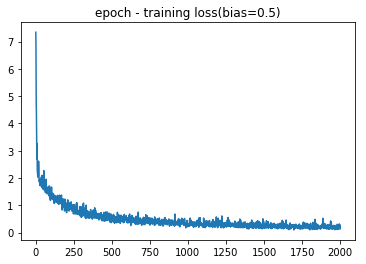

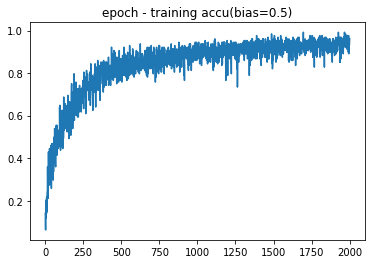

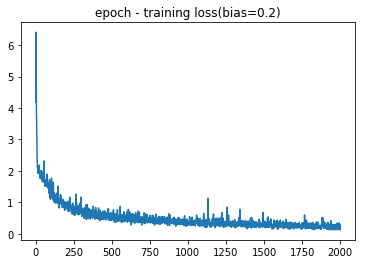

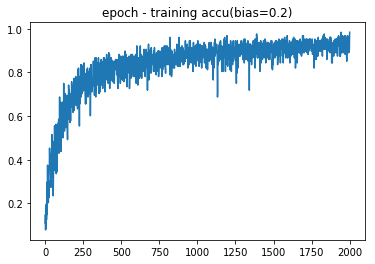

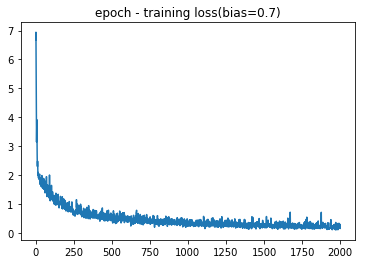

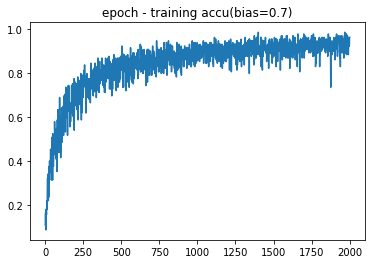

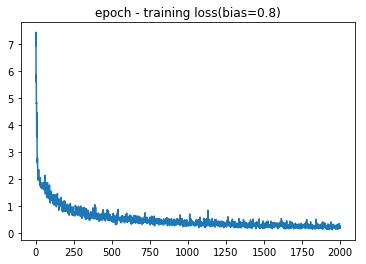

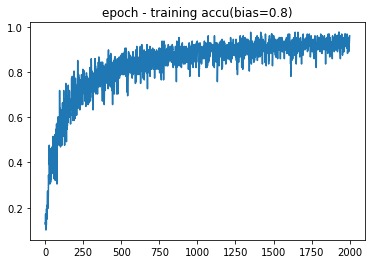

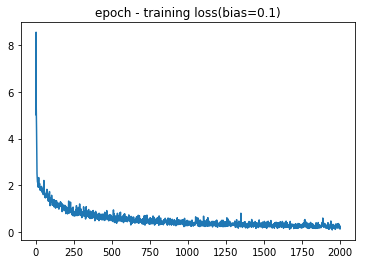

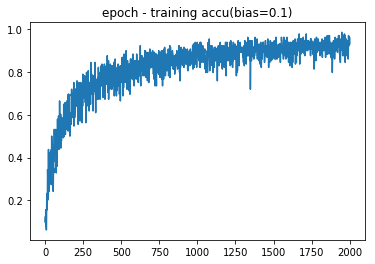

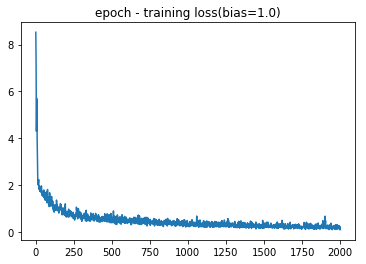

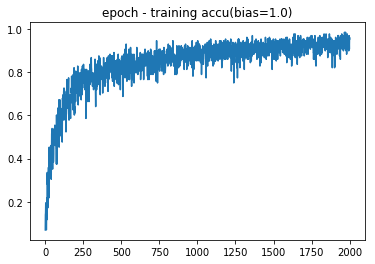

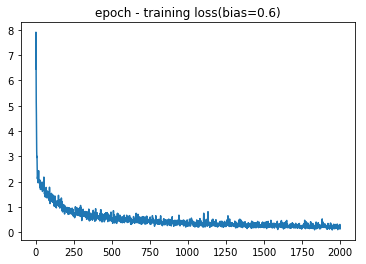

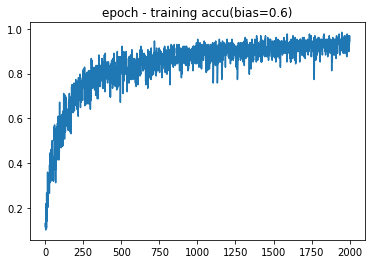

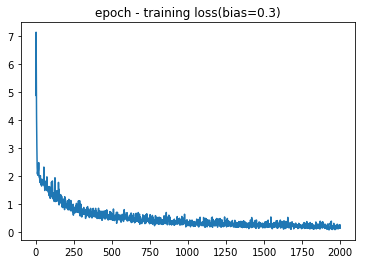

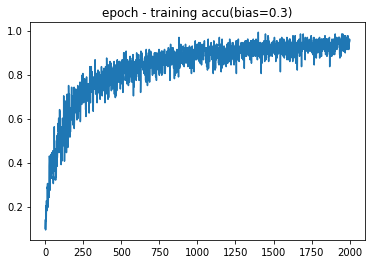

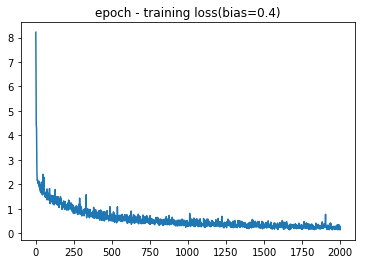

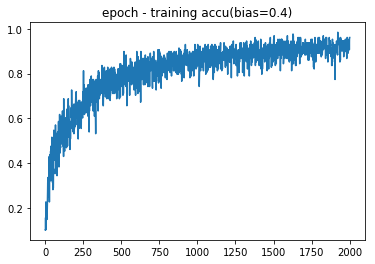

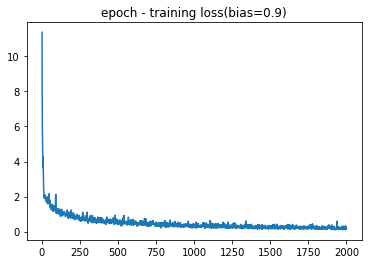

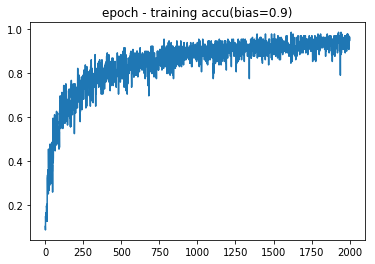

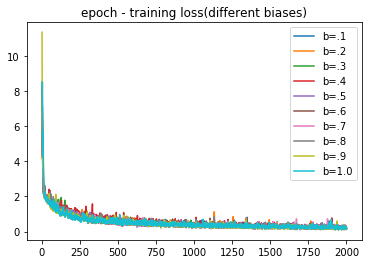

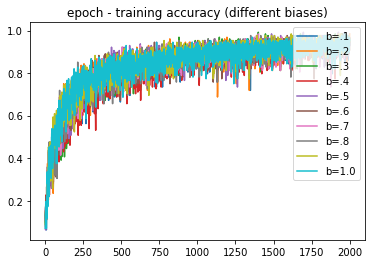

In [3]:
# epoch v.s.training loss
i = 0
for b, losses in loss_val_train.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_train[b][-epoch:])+1), accu_val_train[b][-epoch:])
    plt.title('epoch - training accu('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
plt.close()
plt.plot(range(1, len(loss_val_train['b1'][-epoch:])+1), loss_val_train['b1'][-epoch:], #'b',
         range(1, len(loss_val_train['b2'][-epoch:])+1), loss_val_train['b2'][-epoch:], #'r',
         range(1, len(loss_val_train['b3'][-epoch:])+1), loss_val_train['b3'][-epoch:], #'g',
         range(1, len(loss_val_train['b4'][-epoch:])+1), loss_val_train['b4'][-epoch:], #'k',
         range(1, len(loss_val_train['b5'][-epoch:])+1), loss_val_train['b5'][-epoch:], #'k',
         range(1, len(loss_val_train['b6'][-epoch:])+1), loss_val_train['b6'][-epoch:], #'k',
         range(1, len(loss_val_train['b7'][-epoch:])+1), loss_val_train['b7'][-epoch:], #'k',
         range(1, len(loss_val_train['b8'][-epoch:])+1), loss_val_train['b8'][-epoch:], #'k',
         range(1, len(loss_val_train['b9'][-epoch:])+1), loss_val_train['b9'][-epoch:], #'k',
         range(1, len(loss_val_train['b10'][-epoch:])+1), loss_val_train['b10'][-epoch:]) #'k',)
plt.title('epoch - training loss(different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=1)
plt.savefig('./diffBias_data/epoch_loss_train_.1to1.png')
plt.show()
plt.close()
plt.plot(range(1, len(accu_val_train['b1'][-epoch:])+1), accu_val_train['b1'][-epoch:], #'b',
         range(1, len(accu_val_train['b2'][-epoch:])+1), accu_val_train['b2'][-epoch:], #'r',
         range(1, len(accu_val_train['b3'][-epoch:])+1), accu_val_train['b3'][-epoch:], #'g',
         range(1, len(accu_val_train['b4'][-epoch:])+1), accu_val_train['b4'][-epoch:], #'k',
         range(1, len(accu_val_train['b5'][-epoch:])+1), accu_val_train['b5'][-epoch:], #'k',
         range(1, len(accu_val_train['b6'][-epoch:])+1), accu_val_train['b6'][-epoch:], #'k',
         range(1, len(accu_val_train['b7'][-epoch:])+1), accu_val_train['b7'][-epoch:], #'k',
         range(1, len(accu_val_train['b8'][-epoch:])+1), accu_val_train['b8'][-epoch:], #'k',
         range(1, len(accu_val_train['b9'][-epoch:])+1), accu_val_train['b9'][-epoch:], #'k',
         range(1, len(accu_val_train['b10'][-epoch:])+1), accu_val_train['b10'][-epoch:]) #'k',)
plt.title('epoch - training accuracy (different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=1)
plt.savefig('./diffBias_data/epoch_accu_train_.1to1.png')
plt.show()

### Epoch - Testing loss & accuracy

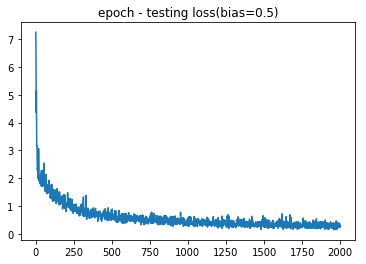

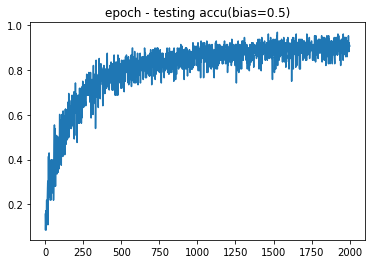

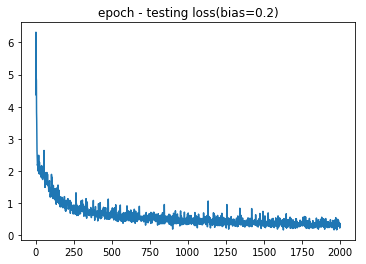

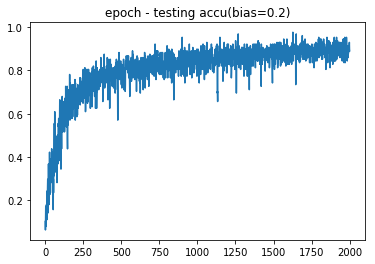

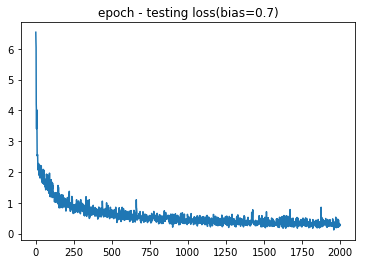

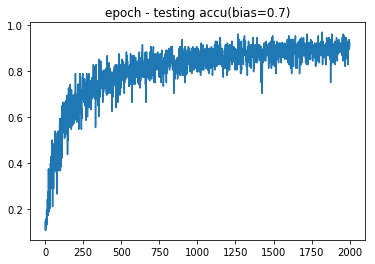

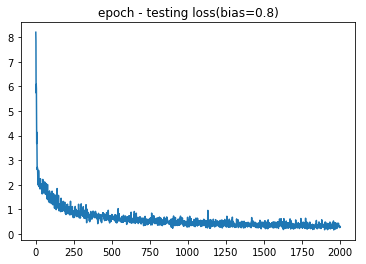

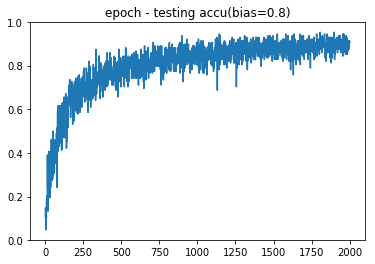

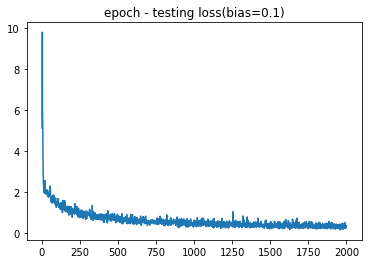

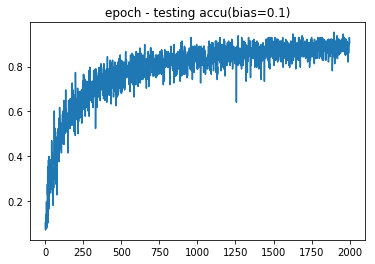

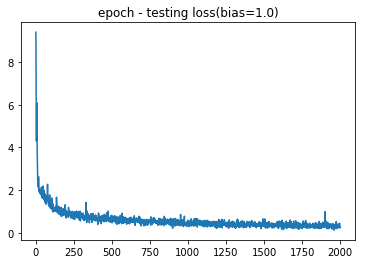

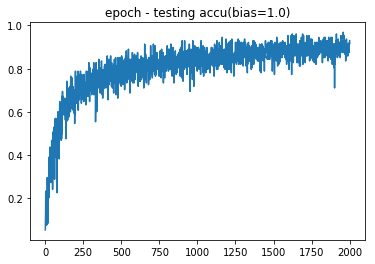

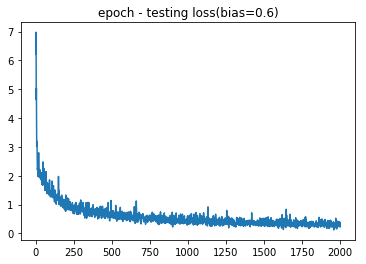

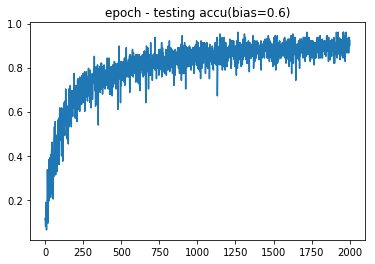

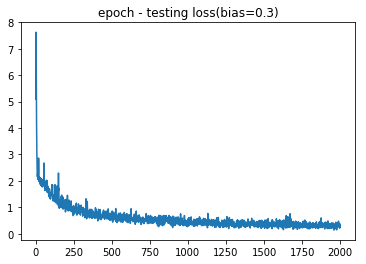

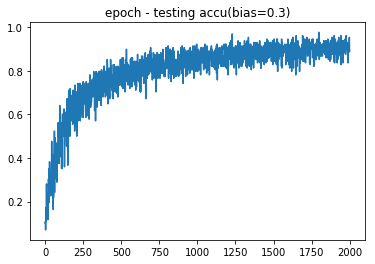

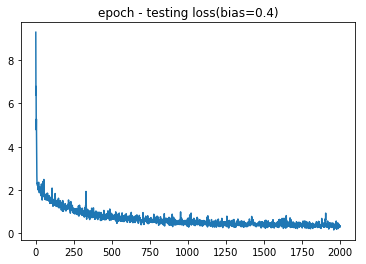

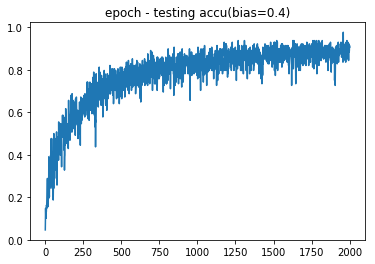

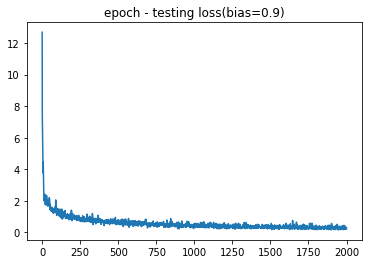

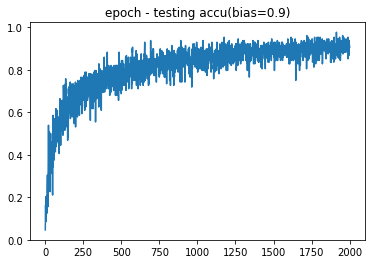

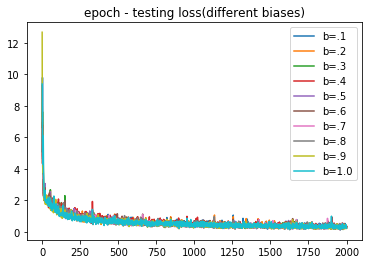

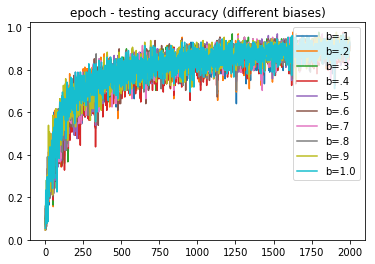

In [4]:
# epoch v.s.testing loss
i = 0
for b, losses in loss_val_test.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - testing loss('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_test[b][-epoch:])+1), accu_val_test[b][-epoch:])
    plt.title('epoch - testing accu('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
plt.close()
plt.plot(range(1, len(loss_val_test['b1'][-epoch:])+1), loss_val_test['b1'][-epoch:], #'b',
         range(1, len(loss_val_test['b2'][-epoch:])+1), loss_val_test['b2'][-epoch:], #'r',
         range(1, len(loss_val_test['b3'][-epoch:])+1), loss_val_test['b3'][-epoch:], #'g',
         range(1, len(loss_val_test['b4'][-epoch:])+1), loss_val_test['b4'][-epoch:], #'k',
         range(1, len(loss_val_test['b5'][-epoch:])+1), loss_val_test['b5'][-epoch:], #'k',
         range(1, len(loss_val_test['b6'][-epoch:])+1), loss_val_test['b6'][-epoch:], #'k',
         range(1, len(loss_val_test['b7'][-epoch:])+1), loss_val_test['b7'][-epoch:], #'k',
         range(1, len(loss_val_test['b8'][-epoch:])+1), loss_val_test['b8'][-epoch:], #'k',
         range(1, len(loss_val_test['b9'][-epoch:])+1), loss_val_test['b9'][-epoch:], #'k',
         range(1, len(loss_val_test['b10'][-epoch:])+1), loss_val_test['b10'][-epoch:]) #'k',)
plt.title('epoch - testing loss(different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=1)
plt.savefig('./diffBias_data/epoch_loss_test_.1to1.png')
plt.show()
plt.close()
plt.plot(range(1, len(accu_val_test['b1'][-epoch:])+1), accu_val_test['b1'][-epoch:], #'b',
         range(1, len(accu_val_test['b2'][-epoch:])+1), accu_val_test['b2'][-epoch:], #'r',
         range(1, len(accu_val_test['b3'][-epoch:])+1), accu_val_test['b3'][-epoch:], #'g',
         range(1, len(accu_val_test['b4'][-epoch:])+1), accu_val_test['b4'][-epoch:], #'k',
         range(1, len(accu_val_test['b5'][-epoch:])+1), accu_val_test['b5'][-epoch:], #'k',
         range(1, len(accu_val_test['b6'][-epoch:])+1), accu_val_test['b6'][-epoch:], #'k',
         range(1, len(accu_val_test['b7'][-epoch:])+1), accu_val_test['b7'][-epoch:], #'k',
         range(1, len(accu_val_test['b8'][-epoch:])+1), accu_val_test['b8'][-epoch:], #'k',
         range(1, len(accu_val_test['b9'][-epoch:])+1), accu_val_test['b9'][-epoch:], #'k',
         range(1, len(accu_val_test['b10'][-epoch:])+1), accu_val_test['b10'][-epoch:]) #'k',)
plt.title('epoch - testing accuracy (different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=1)
plt.savefig('./diffBias_data/epoch_accu_test_.1to1.png')
plt.show()

In [5]:
# smooth the line
last_point = 0
loss_val_train_ = dict()
loss_val_test_ = dict()
accu_val_train_ = dict()
accu_val_test_ = dict()
for b in bs:
    # training loss
    loss_val_train_[b] = list()
    loss_list = loss_val_train[b][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_train_[b].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_train_[b].append(np.mean(loss_list[last_point:]))
    # testing loss
    loss_val_test_[b] = list()
    loss_list = loss_val_test[b][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_test_[b].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_test_[b].append(np.mean(loss_list[last_point:]))
    # training accu
    accu_val_train_[b] = list()
    accu_list = accu_val_train[b][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_train_[b].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_train_[b].append(np.mean(accu_list[last_point:]))
    # testing accu
    accu_val_test_[b] = list()
    accu_list = accu_val_test[b][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_test_[b].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_test_[b].append(np.mean(accu_list[last_point:]))

### Epoch - Training loss & accuracy (smooth)

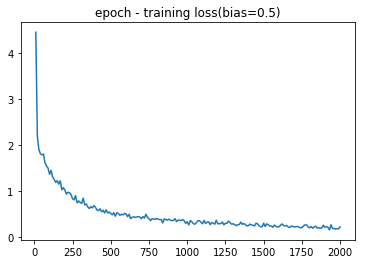

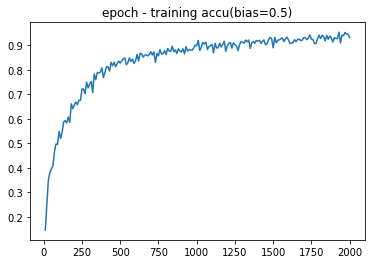

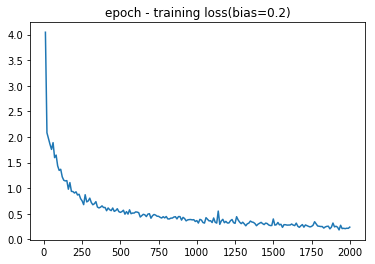

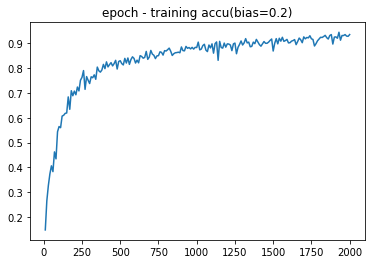

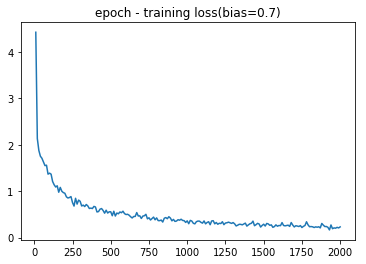

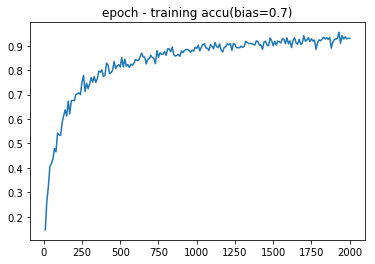

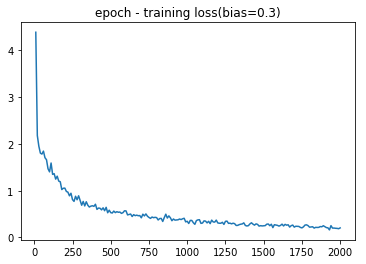

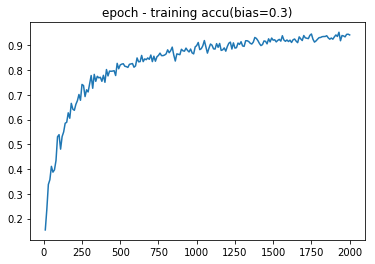

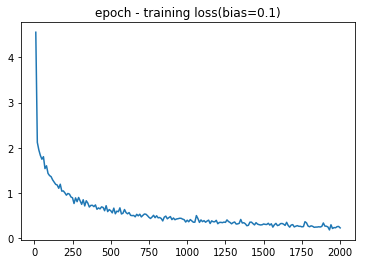

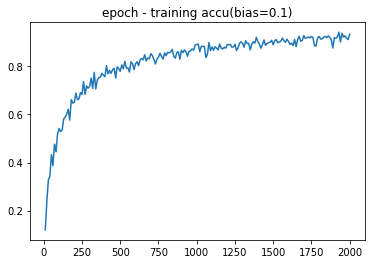

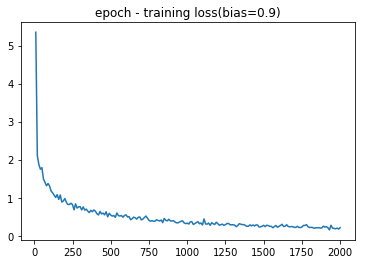

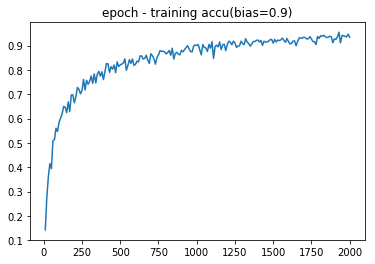

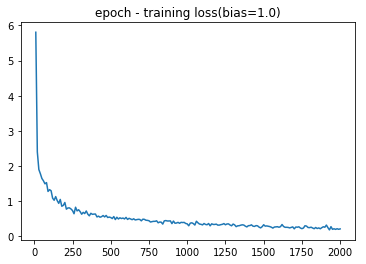

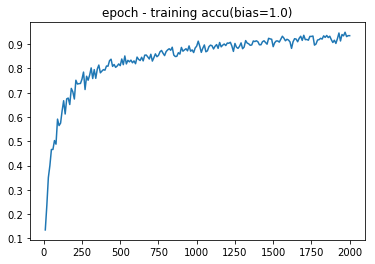

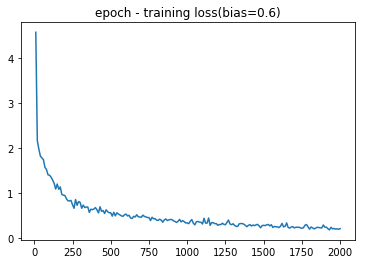

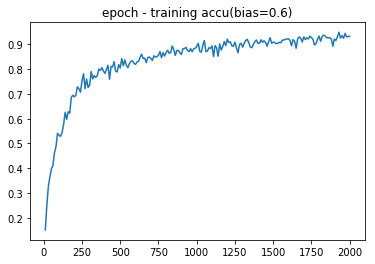

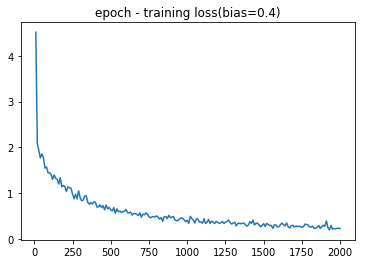

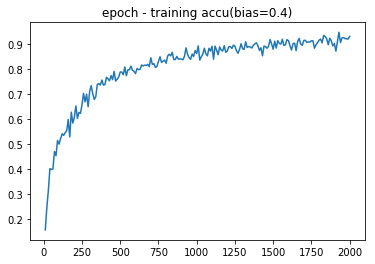

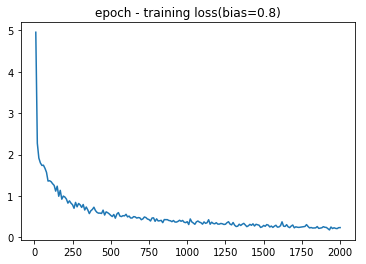

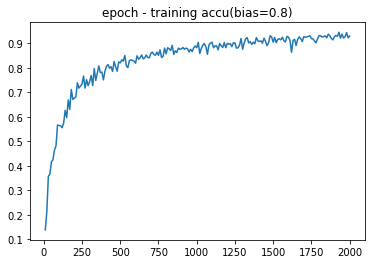

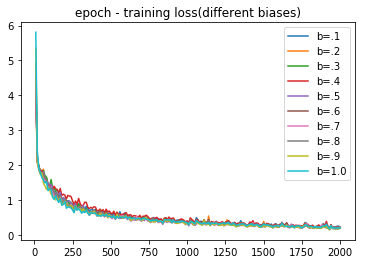

ValueError: x and y must have same first dimension, but have shapes (20,) and (200,)

In [15]:
# epoch v.s.training loss - smooth
i = 0
for b, losses in loss_val_train_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - training loss('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_train_[b][-epoch:])*10+10, 10), accu_val_train_[b][-epoch:])
    plt.title('epoch - training accu('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
plt.close()
plt.plot(range(10, len(loss_val_train_['b1'][-epoch:])*10+10, 10), loss_val_train_['b1'][-epoch:], #'b',
         range(10, len(loss_val_train_['b2'][-epoch:])*10+10, 10), loss_val_train_['b2'][-epoch:], #'r',
         range(10, len(loss_val_train_['b3'][-epoch:])*10+10, 10), loss_val_train_['b3'][-epoch:], #'g',
         range(10, len(loss_val_train_['b4'][-epoch:])*10+10, 10), loss_val_train_['b4'][-epoch:], #'k',
         range(10, len(loss_val_train_['b5'][-epoch:])*10+10, 10), loss_val_train_['b5'][-epoch:], #'k',
         range(10, len(loss_val_train_['b6'][-epoch:])*10+10, 10), loss_val_train_['b6'][-epoch:], #'k',
         range(10, len(loss_val_train_['b7'][-epoch:])*10+10, 10), loss_val_train_['b7'][-epoch:], #'k',
         range(10, len(loss_val_train_['b8'][-epoch:])*10+10, 10), loss_val_train_['b8'][-epoch:], #'k',
         range(10, len(loss_val_train_['b9'][-epoch:])*10+10, 10), loss_val_train_['b9'][-epoch:], #'k',
         range(10, len(loss_val_train_['b10'][-epoch:])*10+10, 10), loss_val_train_['b10'][-epoch:]) #'k',)
plt.title('epoch - training loss(different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=1)
plt.savefig('./diffBias_data/epoch_loss_train_.1to1.png')
plt.show()
plt.close()
plt.plot(range(10, len(accu_val_train_['b1'][-epoch:])*10+10, 10), accu_val_train_['b1'][-epoch:], #'b',
         range(10, len(accu_val_train_['b2'][-epoch:])*10+10, 10), accu_val_train_['b2'][-epoch:], #'r',
         range(10, len(accu_val_train_['b3'][-epoch:])*10+10, 10), accu_val_train_['b3'][-epoch:], #'g',
         range(10, len(accu_val_train_['b4'][-epoch:])*10+10, 10), accu_val_train_['b4'][-epoch:], #'k',
         range(10, len(accu_val_train_['b5'][-epoch:])*10+10, 10), accu_val_train_['b5'][-epoch:], #'k',
         range(10, len(accu_val_train_['b6'][-epoch:])*10+10, 10), accu_val_train_['b6'][-epoch:], #'k',
         range(10, len(accu_val_train_['b7'][-epoch:])*10+10, 10), accu_val_train_['b7'][-epoch:], #'k',
         range(10, len(accu_val_train_['b8'][-epoch:])*10+10, 101), accu_val_train_['b8'][-epoch:], #'k',
         range(10, len(accu_val_train_['b9'][-epoch:])*10+10, 10), accu_val_train_['b9'][-epoch:], #'k',
         range(10, len(accu_val_train_['b10'][-epoch:])*10+10, 10), accu_val_train_['b10'][-epoch:]) #'k',)
plt.title('epoch - training accuracy (different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=4)
plt.savefig('./diffBias_data/epoch_accu_train_.1to1.png')
plt.show()

### Epoch - Testing loss & accuracy (smooth)

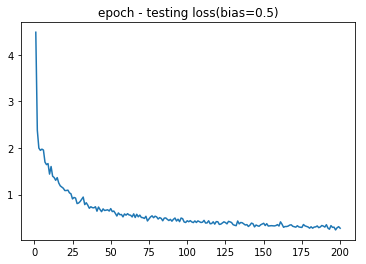

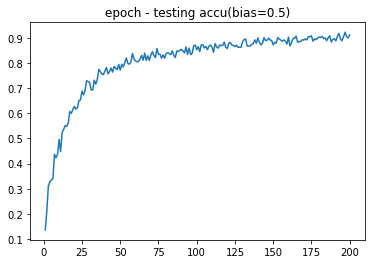

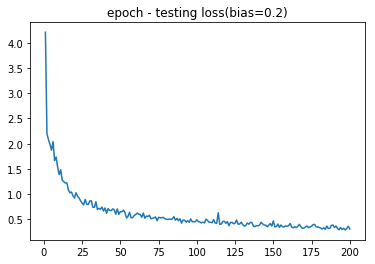

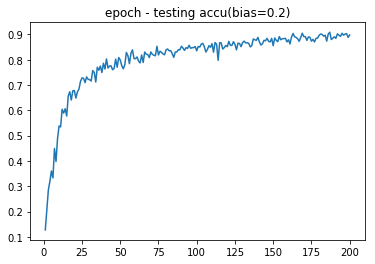

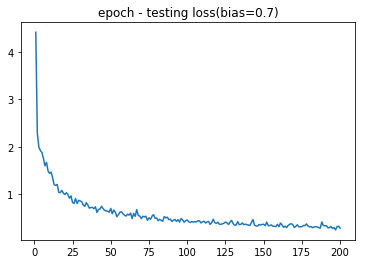

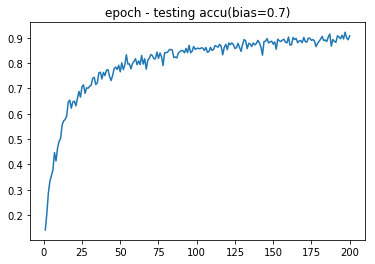

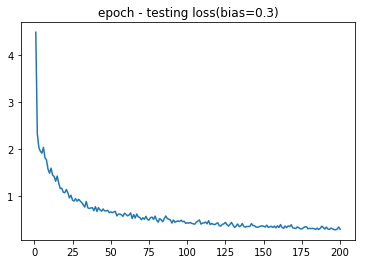

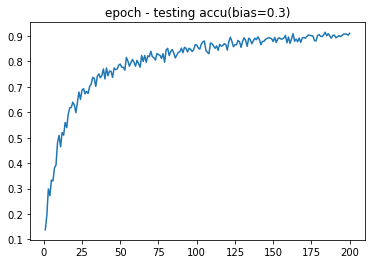

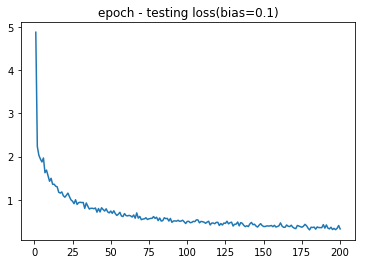

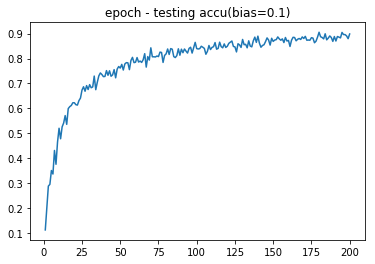

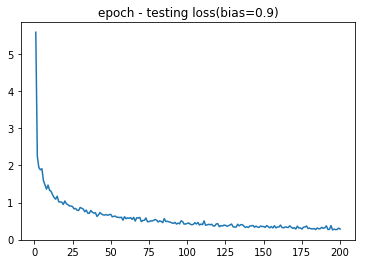

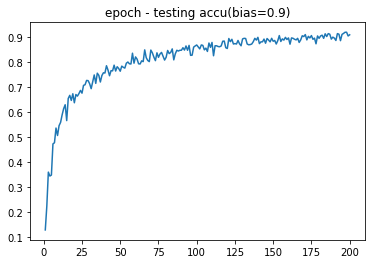

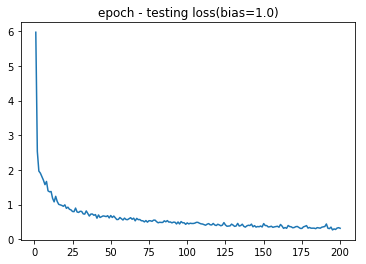

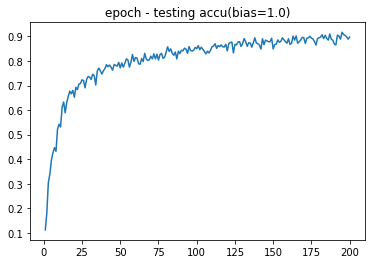

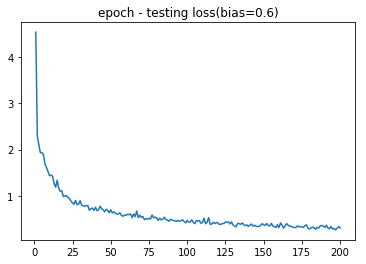

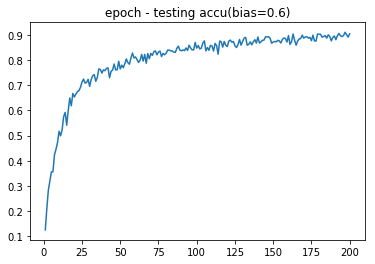

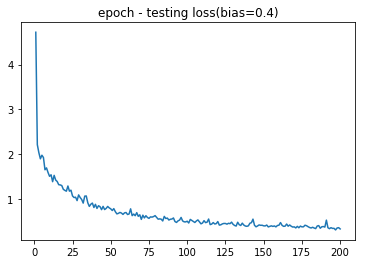

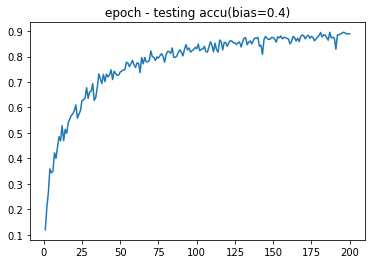

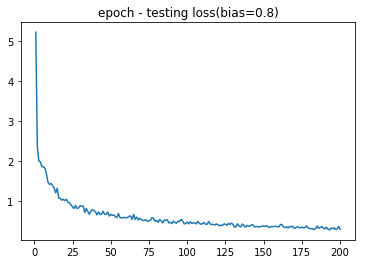

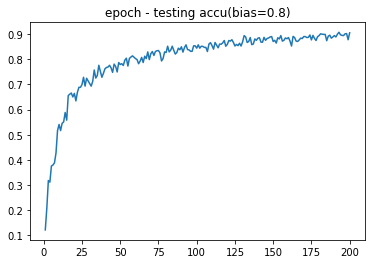

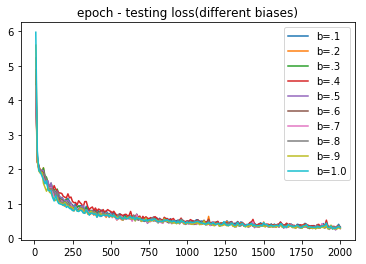

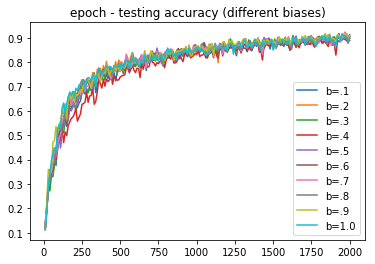

In [16]:
# epoch v.s.testing loss - smooth
i = 0
for b, losses in loss_val_test_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - testing loss('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_test_[b][-epoch:])+1), accu_val_test_[b][-epoch:])
    plt.title('epoch - testing accu('+'bias='+str(float(b[1:])/10)+')')
    plt.show()
    i += 1
plt.close()
plt.plot(range(10, len(loss_val_test_['b1'][-epoch:])*10+10, 10), loss_val_test_['b1'][-epoch:], #'b',
         range(10, len(loss_val_test_['b2'][-epoch:])*10+10, 10), loss_val_test_['b2'][-epoch:], #'r',
         range(10, len(loss_val_test_['b3'][-epoch:])*10+10, 10), loss_val_test_['b3'][-epoch:], #'g',
         range(10, len(loss_val_test_['b4'][-epoch:])*10+10, 10), loss_val_test_['b4'][-epoch:], #'k',
         range(10, len(loss_val_test_['b5'][-epoch:])*10+10, 10), loss_val_test_['b5'][-epoch:], #'k',
         range(10, len(loss_val_test_['b6'][-epoch:])*10+10, 10), loss_val_test_['b6'][-epoch:], #'k',
         range(10, len(loss_val_test_['b7'][-epoch:])*10+10, 10), loss_val_test_['b7'][-epoch:], #'k',
         range(10, len(loss_val_test_['b8'][-epoch:])*10+10, 10), loss_val_test_['b8'][-epoch:], #'k',
         range(10, len(loss_val_test_['b9'][-epoch:])*10+10, 10), loss_val_test_['b9'][-epoch:], #'k',
         range(10, len(loss_val_test_['b10'][-epoch:])*10+10, 10), loss_val_test_['b10'][-epoch:]) #'k',)
plt.title('epoch - testing loss(different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=1)
plt.savefig('./diffBias_data/epoch_loss_test_.1to1.png')
plt.show()
plt.close()
plt.plot(range(10, len(accu_val_test_['b1'][-epoch:])*10+10, 10), accu_val_test_['b1'][-epoch:], #'b',
         range(10, len(accu_val_test_['b2'][-epoch:])*10+10, 10), accu_val_test_['b2'][-epoch:], #'r',
         range(10, len(accu_val_test_['b3'][-epoch:])*10+10, 10), accu_val_test_['b3'][-epoch:], #'g',
         range(10, len(accu_val_test_['b4'][-epoch:])*10+10, 10), accu_val_test_['b4'][-epoch:], #'k',
         range(10, len(accu_val_test_['b5'][-epoch:])*10+10, 10), accu_val_test_['b5'][-epoch:], #'k',
         range(10, len(accu_val_test_['b6'][-epoch:])*10+10, 10), accu_val_test_['b6'][-epoch:], #'k',
         range(10, len(accu_val_test_['b7'][-epoch:])*10+10, 10), accu_val_test_['b7'][-epoch:], #'k',
         range(10, len(accu_val_test_['b8'][-epoch:])*10+10, 10), accu_val_test_['b8'][-epoch:], #'k',
         range(10, len(accu_val_test_['b9'][-epoch:])*10+10, 10), accu_val_test_['b9'][-epoch:], #'k',
         range(10, len(accu_val_test_['b10'][-epoch:])*10+10, 10), accu_val_test_['b10'][-epoch:]) #'k',)
plt.title('epoch - testing accuracy (different biases)')
plt.legend(['b=.1', 'b=.2', 'b=.3', 'b=.4', 'b=.5', 'b=.6', 'b=.7', 'b=.8', 'b=.9', 'b=1.0'], loc=4)
plt.savefig('./diffBias_data/epoch_accu_test_.1to1.png')
plt.show()

# Statistics Inference : ANOVA and T-test

In [8]:
from scipy import stats as st
# ANOVA:  f_val, p_val = st.f_oneway(data_array1, data_array2, ...)

In [9]:
# data extract
loss_means_train = dict()
for bias, losses in loss_val_train.items():
    mean = list()
    ex_time = len(losses)/epoch
    #print(bias, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_train[bias] = mean

loss_means_test = dict()
for bias, losses in loss_val_test.items():
    mean = list()
    ex_time = len(losses)/epoch
    #print(bias, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_test[bias] = mean
    
accu_means_train = dict()
for bias, losses in accu_val_train.items():
    mean = list()
    ex_time = len(losses)/epoch
    #print(bias, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_train[bias] = mean

accu_means_test = dict()
for bias, losses in accu_val_test.items():
    mean = list()
    ex_time = len(losses)/epoch
    #print(bias, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_test[bias] = mean

In [10]:
np.save('./diffBias_data/loss_means_train_diffBias_.1to1', loss_means_train)
np.save('./diffBias_data/loss_means_test_diffBias_.1to1', loss_means_test)
np.save('./diffBias_data/accu_means_train_diffBias_.1to1', accu_means_train)
np.save('./diffBias_data/accu_means_test_diffBias_.1to1', accu_means_test)
loss_means_train, loss_means_test, accu_means_train, accu_means_test

({'b1': [0.20047079,
   0.21448465,
   0.22412394,
   0.19274595,
   0.22240597,
   0.21412048,
   0.18476161,
   0.28451118,
   0.21626236,
   0.24304447],
  'b10': [0.1738497,
   0.17937608,
   0.20442398,
   0.1792555,
   0.18412524,
   0.20445082,
   0.17583787,
   0.2263319,
   0.19239321,
   0.2260724],
  'b2': [0.21638496,
   0.23472795,
   0.24604456,
   0.20254429,
   0.20906249,
   0.23786667,
   0.21282709,
   0.22690658,
   0.20890038,
   0.22394918],
  'b3': [0.20096584,
   0.19371283,
   0.22475299,
   0.20151505,
   0.20573625,
   0.24781252,
   0.2101209,
   0.24656363,
   0.19722648,
   0.20198965],
  'b4': [0.17812747,
   0.17417191,
   0.20388964,
   0.17426871,
   0.19462134,
   0.22439256,
   0.25040671,
   0.23823957,
   0.20022038,
   0.25340477],
  'b5': [0.20212965,
   0.18788575,
   0.21281502,
   0.18633616,
   0.20380777,
   0.22792217,
   0.22124867,
   0.22910316,
   0.20945509,
   0.20353009],
  'b6': [0.18312937,
   0.19044465,
   0.23199475,
   0.181507

### training loss

F value: 1.58821519438 , P value: 0.130713687458
They are identical.
     bias    mean     StD    
     b10    0.1946   0.0189
      b9    0.1994   0.0169
      b7    0.2030   0.0189
      b8    0.2063   0.0195
      b6    0.2081   0.0181
      b5    0.2084   0.0141
      b4    0.2092   0.0291
      b3    0.2130   0.0189
      b1    0.2197   0.0268
      b2    0.2219   0.0136


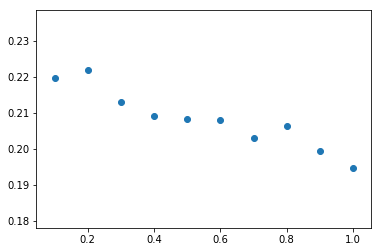

In [11]:
# ANOVA - find that whether biases effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(loss_means_train['b1'],
                           loss_means_train['b2'],
                           loss_means_train['b3'],
                           loss_means_train['b4'],
                           loss_means_train['b5'],
                           loss_means_train['b6'],
                           loss_means_train['b7'],
                           loss_means_train['b8'],
                           loss_means_train['b9'],
                           loss_means_train['b10'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')

# sort them by means
mean = dict()
StD = dict()
for bias, mu in loss_means_train.items():
    mean[bias] = np.mean(mu)
    StD[bias] = np.std(mu)
mus_sort = sorted(mean.values())
bs_sort = sorted(mean, key=mean.__getitem__)
print('     bias    mean     StD    ')
for i in range(len(bs_sort)):
    print('%8s    %2.4f   %2.4f' % (bs_sort[i], mus_sort[i], StD[bs_sort[i]]))

# bias v.s. loss means - ploting
mus = list()
b = list()
for i in range(10):
    b.append(float(bs_sort[i][1:])/10)
    mus.append(mus_sort[i])
plt.scatter(b, mus)
plt.savefig('./diffBias_data/bias_loss_train_.1to1.png')
plt.show()

### training accuracy

F value: 1.64567791865 , P value: 0.11428407715
They are identical.
     bias    mean     StD    
      b2    0.9309   0.0047
      b1    0.9320   0.0090
      b3    0.9349   0.0065
      b4    0.9353   0.0101
      b5    0.9358   0.0060
      b6    0.9359   0.0056
      b8    0.9369   0.0070
      b7    0.9380   0.0070
      b9    0.9392   0.0053
     b10    0.9406   0.0070


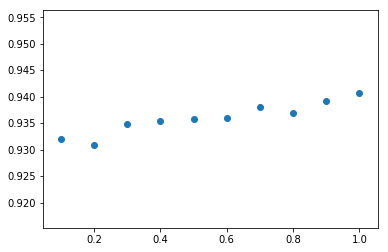

In [12]:
# ANOVA - find that whether biases effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(accu_means_train['b1'],
                           accu_means_train['b2'],
                           accu_means_train['b3'],
                           accu_means_train['b4'],
                           accu_means_train['b5'],
                           accu_means_train['b6'],
                           accu_means_train['b7'],
                           accu_means_train['b8'],
                           accu_means_train['b9'],
                           accu_means_train['b10'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')

# sort them by means
mean = dict()
StD = dict()
for bias, mu in accu_means_train.items():
    mean[bias] = np.mean(mu)
    StD[bias] = np.std(mu)
mus_sort = sorted(mean.values())
bs_sort = sorted(mean, key=mean.__getitem__)
print('     bias    mean     StD    ')
for i in range(len(bs_sort)):
    print('%8s    %2.4f   %2.4f' % (bs_sort[i], mus_sort[i], StD[bs_sort[i]]))

# bias v.s. loss means - ploting
mus = list()
b = list()
for i in range(10):
    b.append(float(bs_sort[i][1:])/10)
    mus.append(mus_sort[i])
plt.scatter(b, mus)
plt.savefig('./diffBias_data/bias_accu_train_.1to1.png')
plt.show()

### testing loss

F value: 1.05212033689 , P value: 0.405867876877
They are identical.
     bias    mean     StD    
     b10    0.2824   0.0231
      b9    0.2896   0.0207
      b7    0.2904   0.0200
      b6    0.2916   0.0196
      b5    0.2945   0.0181
      b8    0.2953   0.0198
      b4    0.2968   0.0356
      b3    0.3001   0.0211
      b1    0.3053   0.0285
      b2    0.3091   0.0159


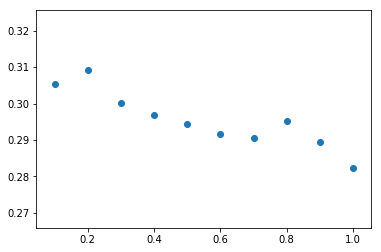

In [13]:
# ANOVA - find that whether biases effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(loss_means_test['b1'],
                           loss_means_test['b2'],
                           loss_means_test['b3'],
                           loss_means_test['b4'],
                           loss_means_test['b5'],
                           loss_means_test['b6'],
                           loss_means_test['b7'],
                           loss_means_test['b8'],
                           loss_means_test['b9'],
                           loss_means_test['b10'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')

# sort them by means
mean = dict()
StD = dict()
for bias, mu in loss_means_test.items():
    mean[bias] = np.mean(mu)
    StD[bias] = np.std(mu)
mus_sort = sorted(mean.values())
bs_sort = sorted(mean, key=mean.__getitem__)
print('     bias    mean     StD    ')
for i in range(len(bs_sort)):
    print('%8s    %2.4f   %2.4f' % (bs_sort[i], mus_sort[i], StD[bs_sort[i]]))

# bias v.s. loss means - ploting
mus = list()
b = list()
for i in range(10):
    b.append(float(bs_sort[i][1:])/10)
    mus.append(mus_sort[i])
plt.scatter(b, mus)
plt.savefig('./diffBias_data/bias_loss_test_.1to1.png')
plt.show()

### testing accuracy

F value: 1.41493507247 , P value: 0.193562621942
They are identical.
     bias    mean     StD    
      b2    0.8994   0.0060
      b1    0.9002   0.0096
      b3    0.9026   0.0074
      b4    0.9031   0.0116
      b5    0.9046   0.0058
      b8    0.9048   0.0059
      b6    0.9056   0.0064
      b7    0.9069   0.0070
      b9    0.9072   0.0070
     b10    0.9086   0.0070


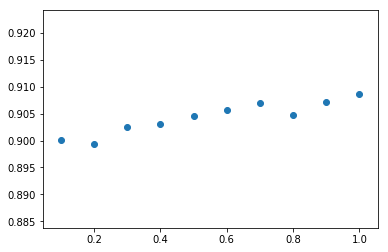

In [14]:
# ANOVA - find that whether biases effect the training loss or not
alpha = 0.05
f_val, p_val = st.f_oneway(accu_means_test['b1'],
                           accu_means_test['b2'],
                           accu_means_test['b3'],
                           accu_means_test['b4'],
                           accu_means_test['b5'],
                           accu_means_test['b6'],
                           accu_means_test['b7'],
                           accu_means_test['b8'],
                           accu_means_test['b9'],
                           accu_means_test['b10'])
print('F value:', f_val, ', P value:', p_val)
if p_val <= alpha:
    print('They are NOT identical at all.')
else:
    print('They are identical.')

# sort them by means
mean = dict()
StD = dict()
for bias, mu in accu_means_test.items():
    mean[bias] = np.mean(mu)
    StD[bias] = np.std(mu)
mus_sort = sorted(mean.values())
bs_sort = sorted(mean, key=mean.__getitem__)
print('     bias    mean     StD    ')
for i in range(len(bs_sort)):
    print('%8s    %2.4f   %2.4f' % (bs_sort[i], mus_sort[i], StD[bs_sort[i]]))

# bias v.s. loss means - ploting
mus = list()
b = list()
for i in range(10):
    b.append(float(bs_sort[i][1:])/10)
    mus.append(mus_sort[i])
plt.scatter(b, mus)
plt.savefig('./diffBias_data/bias_accu_test_.1to1.png')
plt.show()